This is the first setup file intendend to perform premiliay setup of initial problem 

In [73]:
using Oceananigans
using Oceananigans.Units: minute, minutes, hours, day

In [74]:
using Random
using Printf
using Plots


In [75]:
grid = RectilinearGrid(size = (64, 64, 32),
                          x = (0, 2*pi),
                          y = (0, 2*pi),
                          z = (-30,0))

RectilinearGrid{Float64, Periodic, Periodic, Bounded}
             architecture: CPU()
                   domain: x ∈ [0.0, 6.283185307179586], y ∈ [0.0, 6.283185307179586], z ∈ [-30.0, 0.0]
                 topology: (Periodic, Periodic, Bounded)
        size (Nx, Ny, Nz): (64, 64, 32)
        halo (Hx, Hy, Hz): (1, 1, 1)
             spacing in x: Regular, with spacing 0.09817477042468103
             spacing in y: Regular, with spacing 0.09817477042468103
             spacing in z: Regular, with spacing 0.9375

In [4]:
buoyancy_flux(x, y,z, params) = params.initial_buoyancy_flux*z

buoyancy_flux_parameters = (initial_buoyancy_flux = 1e-8, # m² s⁻³    
    shut_off_time = 2hours)

buoyancy_flux_bc = FluxBoundaryCondition(buoyancy_flux, parameters = buoyancy_flux_parameters)

BoundaryCondition: classification=Flux, condition=buoyancy_flux(x, y, z, t, params) in Main at In[4]:1

In [46]:
flux_plot = plot([buoyancy_flux(1, 1,grid.zᵃᵃᶠ, 0, buoyancy_flux_parameters) for t in times],
                 grid.zᵃᵃᶠ,linewidth = 2, xlabel = "Surface buoyancy flux (m² s⁻³)", ylabel ="Z(m)" ,
                 size = (800, 300), margin = 5mm, label = nothing)

LoadError: UndefVarError: times not defined

In [4]:
N² = 1e-4 # s⁻²

buoyancy_gradient_bc = GradientBoundaryCondition(N²)

BoundaryCondition: classification=Gradient, condition=0.0001

In [7]:
buoyancy_bcs = FieldBoundaryConditions(top = buoyancy_flux_bc)
#buoyancy_bcs = FieldBoundaryConditions(top = buoyancy_flux_bc, bottom = buoyancy_gradient_bc)

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Float64}
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Oceananigans.BoundaryConditions.ContinuousBoundaryFunction{Nothing, Nothing, Nothing, Nothing, typeof(buoyancy_flux), NamedTuple{(:initial_buoyancy_flux, :shut_off_time), Tuple{Float64, Float64}}, Tuple{}, Nothing, Nothing}}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

In [81]:
model = NonhydrostaticModel(grid = grid,
              advection = UpwindBiasedFifthOrder(),
            timestepper = :RungeKutta3,
               coriolis = FPlane(f=1e-4),
         tracers = (:b),
    closure = ScalarDiffusivity(ν=1e-5)
#     boundary_conditions = (b=buoyancy_bcs,)
                           )

LoadError: UndefVarError: ScalarDiffusivity not defined

In [7]:
using Statistics

u, v, w = model.velocities

uᵢ = rand(size(u)...)
vᵢ = rand(size(v)...)
wᵢ = rand(size(w)...)

uᵢ .-= mean(uᵢ)
vᵢ .-= mean(vᵢ)
wᵢ .-= mean(wᵢ)

64×64×33 Array{Float64, 3}:
[:, :, 1] =
  0.184954    0.0188532   0.00146831  …   0.0470082   0.390042     0.0285153
  0.11325    -0.0632686  -0.176702        0.482817   -0.00512471  -0.23246
 -0.0515202  -0.360651    0.064055       -0.100135   -0.41697      0.472222
 -0.0448179   0.461458    0.229486       -0.217485   -0.232398     0.441943
 -0.244613   -0.203256    0.0903697       0.20426     0.413683    -0.0372375
 -0.0673944  -0.198624   -0.410637    …  -0.100085    0.0173703    0.154457
 -0.0791478   0.253452   -0.443036       -0.0714992   0.00441573  -0.286169
 -0.025669    0.0842906  -0.0530262       0.0390258   0.341044    -0.0722389
 -0.130052    0.389943   -0.44685         0.102334    0.13193      0.289843
  0.464576    0.470247    0.0811416       0.163235    0.443235     0.296072
 -0.351833    0.372515   -0.429533    …  -0.327091    0.47382      0.130809
  0.197906    0.0522308   0.00315227      0.363181   -0.243393     0.385335
  0.357931   -0.078408   -0.441609        0.03

In [68]:
mixed_layer_depth = 30 # m

# stratification(z) = z < -mixed_layer_depth ? N² * z : - N² * mixed_layer_depth
stratification(z) =  N² * z 

#noise(z) = 1e-4 * N² * grid.Lz * randn() * exp(z / 4)

initial_buoyancy(x, y, z) = stratification(z) 

set!(model, u=uᵢ, v=vᵢ,w=wᵢ,b=initial_buoyancy)

In [57]:
u, v, w = model.velocities

(u = Field located at (Face, Center, Center)
├── data: OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, size: (64, 64, 32)
├── grid: RectilinearGrid{Float64, Periodic, Periodic, Bounded}(Nx=64, Ny=64, Nz=32)
└── boundary conditions: west=Periodic, east=Periodic, south=Periodic, north=Periodic, bottom=ZeroFlux, top=ZeroFlux, immersed=ZeroFlux, v = Field located at (Center, Face, Center)
├── data: OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, size: (64, 64, 32)
├── grid: RectilinearGrid{Float64, Periodic, Periodic, Bounded}(Nx=64, Ny=64, Nz=32)
└── boundary conditions: west=Periodic, east=Periodic, south=Periodic, north=Periodic, bottom=ZeroFlux, top=ZeroFlux, immersed=ZeroFlux, w = Field located at (Center, Center, Face)
├── data: OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, size: (64, 64, 33)
├── grid: RectilinearGrid{Float64, Periodic, Periodic, Bounded}(Nx=64, Ny=64, Nz=32)
└── boundary conditions: west=Periodic, east=Periodic, south=Periodic, north=Per

In [58]:
# ωx = ∂y(w) - ∂z(v)
# ωy = ∂z(u) - ∂x(w)
ωz = ∂x(v) - ∂y(u)

ω_field = Field(ωz)

Field located at (Center, Face, Face) computed from UnaryOperation at (Center, Face, Face)
├── data: OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, size: (64, 64, 33)
├── grid: RectilinearGrid{Float64, Periodic, Periodic, Bounded}(Nx=64, Ny=64, Nz=32)
├── operand: UnaryOperation at (Center, Face, Face)
└── status: time=0.0

In [59]:
s = sqrt(u^2 + v^2+w^2)

s_field = Field(s)

Field located at (Face, Center, Center) computed from UnaryOperation at (Face, Center, Center)
├── data: OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, size: (64, 64, 32)
├── grid: RectilinearGrid{Float64, Periodic, Periodic, Bounded}(Nx=64, Ny=64, Nz=32)
├── operand: UnaryOperation at (Face, Center, Center)
└── status: time=0.0

In [69]:
simulation = Simulation(model, Δt=0.05, stop_time=30)

Simulation{typename(NonhydrostaticModel){typename(CPU), Float64}}
├── Model clock: time = 30.100 seconds, iteration = 607
├── Next time step: 50 ms
├── Elapsed wall time: 0 seconds
├── Stop time: 30 seconds
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: typename(OrderedCollections.OrderedDict) with 4 entries:
│   ├── stop_time_exceeded => typename(Callback)
│   ├── stop_iteration_exceeded => typename(Callback)
│   ├── wall_time_limit_exceeded => typename(Callback)
│   └── nan_checker => typename(Callback)
├── Output writers: typename(OrderedCollections.OrderedDict) with no entries
└── Diagnostics: typename(OrderedCollections.OrderedDict) with no entries

In [61]:
progress(sim) = @info "Iteration: $(iteration(sim)), time: $(time(sim))"

simulation.callbacks[:progress] = Callback(progress, IterationInterval(100))

Callback{typeof(progress), IterationInterval}(progress, IterationInterval(100))

In [70]:
averaged_bouyancy = Field(Average(model.tracers.b, dims=(1, 2)))
simulation.output_writers[:field_writer] =
    NetCDFOutputWriter(model, (ω=ω_field, s=s_field,b_avg=averaged_bouyancy), filepath="Three_dimensional_turbulence_no_bouy_grad_1.nc", schedule=TimeInterval(1))

NetCDFOutputWriter scheduled on TimeInterval(1 second):
├── filepath: Three_dimensional_turbulence_no_bouy_grad_1.nc
├── dimensions: zC(32), zF(33), xC(64), yF(64), xF(64), yC(64), time(0)
├── 3 outputs: ["b_avg", "ω", "s"]
├── field slicer: FieldSlicer(:, :, :, with_halos=false)
└── array type: Array{Float32}

In [72]:
run!(simulation)


┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:168
┌ Info:     ... simulation initialization complete (23.345 ms)
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:190
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:113
┌ Info:     ... initial time step complete (196.969 ms).
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:120
┌ Info: Simulation is stopping. Model time 30.200 seconds has hit or exceeded simulation stop time 30 seconds.
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\simulation.jl:164


In [53]:
using NCDatasets, Plots, Printf

# file = open(simulation.output_writers[:field_writer].filepath)

# iterations = parse.(Int, keys(file["timeseries/t"]))

In [54]:
xω, yω, zω = nodes(ω_field)
xs, ys, zs = nodes(s_field)
xb,yb,zb= nodes(model.tracers.b)

([0.04908738521234052, 0.14726215563702155, 0.2454369260617026, 0.3436116964863836, 0.44178646691106466, 0.5399612373357457, 0.6381360077604268, 0.7363107781851078, 0.8344855486097889, 0.9326603190344699  …  5.350524988145116, 5.448699758569798, 5.546874528994478, 5.64504929941916, 5.743224069843841, 5.841398840268521, 5.939573610693203, 6.037748381117884, 6.135923151542564, 6.234097921967246], [0.04908738521234052, 0.14726215563702155, 0.2454369260617026, 0.3436116964863836, 0.44178646691106466, 0.5399612373357457, 0.6381360077604268, 0.7363107781851078, 0.8344855486097889, 0.9326603190344699  …  5.350524988145116, 5.448699758569798, 5.546874528994478, 5.64504929941916, 5.743224069843841, 5.841398840268521, 5.939573610693203, 6.037748381117884, 6.135923151542564, 6.234097921967246], [-29.53125, -28.59375, -27.65625, -26.71875, -25.78125, -24.84375, -23.90625, -22.96875, -22.03125, -21.09375  …  -8.90625, -7.96875, -7.03125, -6.09375, -5.15625, -4.21875, -3.28125, -2.34375, -1.40625, -

In [55]:
ds = NCDataset(simulation.output_writers[:field_writer].filepath, "r")

@info "Making a neat movie of vorticity and speed..."

anim = @animate for (iter, t) in enumerate(ds["time"])

#     @info "Plotting frame $i from iteration $iteration..."

#     t = file["timeseries/t/$iteration"]
    ω_snapshot = ds["ω"][:, :, 1,iter]
    s_snapshot = ds["s"][:, :, 1,iter]
    averaged_bou = ds["b_avg"][:,iter]
    ω_lim = 2.0
    ω_levels = range(-ω_lim, stop=ω_lim, length=20)

    s_lim = 0.2
    s_levels = range(0, stop=s_lim, length=20)

    kwargs = (xlabel="x", ylabel="y", aspectratio=1, linewidth=0, colorbar=true,
              xlims=(0, model.grid.Lx), ylims=(0, model.grid.Ly))

    ω_plot = contourf(xω, yω, clamp.(ω_snapshot', -ω_lim, ω_lim);
                       color = :balance,
                      levels = ω_levels,
                       clims = (-ω_lim, ω_lim),
                      kwargs...)

    s_plot = contourf(xs, ys, clamp.(s_snapshot', 0, s_lim);
                       color = :thermal,
                      levels = s_levels,
                       clims = (0., s_lim),
                      kwargs...)
    b_profile = plot(averaged_bou, zb,
                     linewidth = 2,
                     label = nothing,
                     ylabel = "Z (m)",
                     xlabel = "bouyancy")

    plot(ω_plot, s_plot, b_profile,title=["Vorticity" "Speed" "Bouyancy"], layout=(1, 3), size=(1200, 500))
end
close(ds)

┌ Info: Making a neat movie of vorticity and speed...
└ @ Main In[55]:3


Animation("C:\\Users\\shiva\\AppData\\Local\\Temp\\jl_UgL4AP", ["000001.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\shiva\Desktop\CALTECH_ocean\Sea Ice Atmos Intraction\Setup1.gif
└ @ Plots C:\Users\shiva\.julia\packages\Plots\FCM0H\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\shiva\\Desktop\\CALTECH_ocean\\Sea Ice Atmos Intraction\\Setup1.gif")
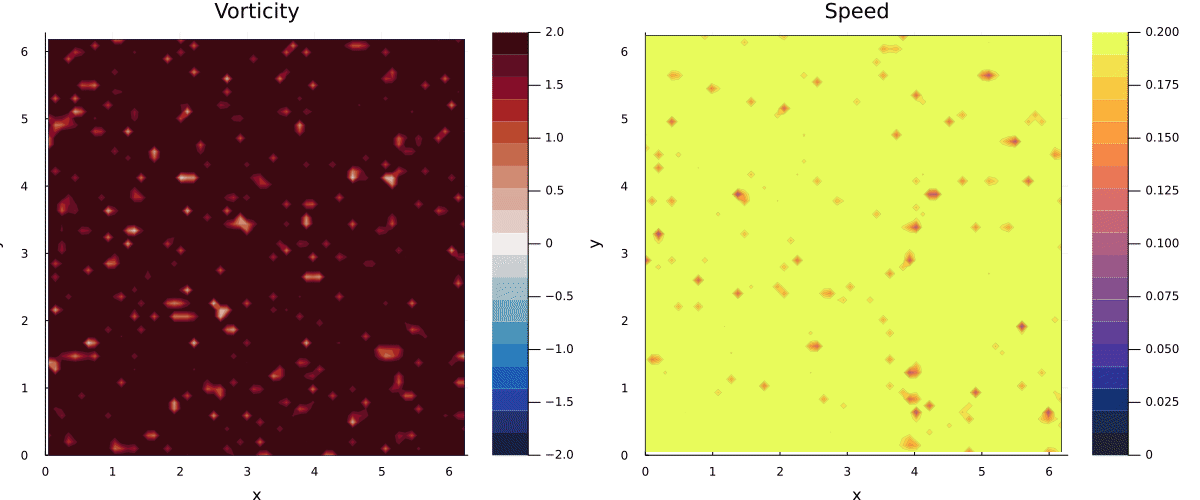

In [22]:
gif(anim,"Setup1.gif",fps=20)

┌ Info: Saved animation to 
│   fn = C:\Users\shiva\Desktop\CALTECH_ocean\Sea Ice Atmos Intraction\Setup1.gif
└ @ Plots C:\Users\shiva\.julia\packages\Plots\FCM0H\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\shiva\\Desktop\\CALTECH_ocean\\Sea Ice Atmos Intraction\\Setup1.gif")
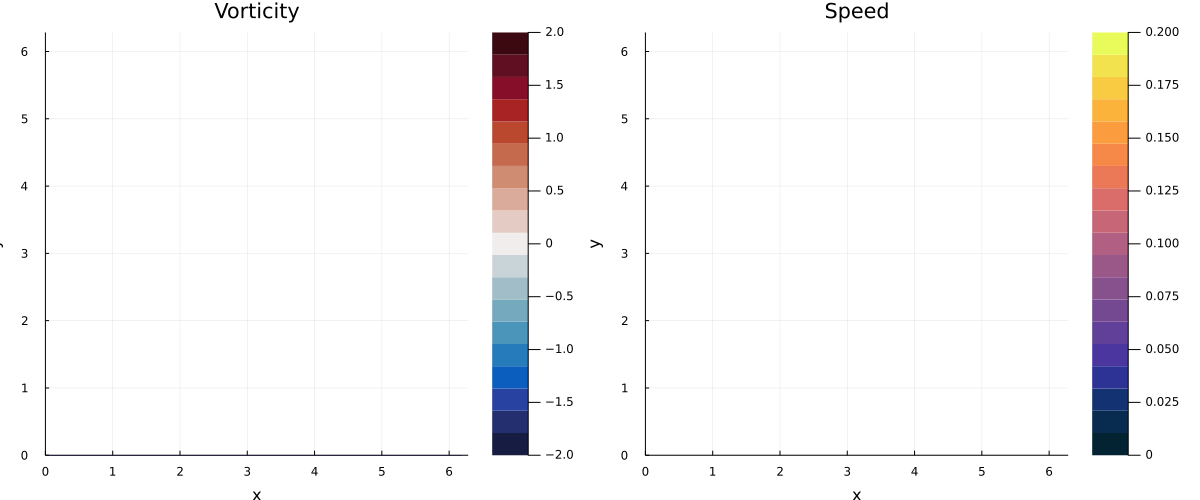

In [50]:
gif(anim,"Setup1.gif",fps=20)

In [46]:
mp4(anim, "Setup1.mp4", fps=15)

┌ Info: Saved animation to 
│   fn = C:\Users\shiva\Desktop\CALTECH_ocean\Sea Ice Atmos Intraction\Setup1.mp4
└ @ Plots C:\Users\shiva\.julia\packages\Plots\FCM0H\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\shiva\\Desktop\\CALTECH_ocean\\Sea Ice Atmos Intraction\\Setup1.mp4")

In [51]:
mp4(anim, "Setup4.mp4", fps=15)

┌ Info: Saved animation to 
│   fn = C:\Users\shiva\Desktop\CALTECH_ocean\Sea Ice Atmos Intraction\Setup4.mp4
└ @ Plots C:\Users\shiva\.julia\packages\Plots\FCM0H\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\shiva\\Desktop\\CALTECH_ocean\\Sea Ice Atmos Intraction\\Setup4.mp4")

In [22]:
mp4(anim, "Setup_stable_bouyancy.mp4", fps=15)

┌ Info: Saved animation to 
│   fn = C:\Users\shiva\Desktop\CALTECH_ocean\Sea Ice Atmos Intraction\Setup_stable_bouyancy.mp4
└ @ Plots C:\Users\shiva\.julia\packages\Plots\FCM0H\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\shiva\\Desktop\\CALTECH_ocean\\Sea Ice Atmos Intraction\\Setup_stable_bouyancy.mp4")

In [29]:
averaged_bou = ds["b_avg"]
# plot(averaged_bou[:,1],averaged_bou[1,:])

b_avg (32 × 31)
  Datatype:    Float32
  Dimensions:  zC × time


In [44]:
mp4(anim, "Setup_stable_bouyancy1.mp4", fps=15)

┌ Info: Saved animation to 
│   fn = C:\Users\shiva\Desktop\CALTECH_ocean\Sea Ice Atmos Intraction\Setup_stable_bouyancy1.mp4
└ @ Plots C:\Users\shiva\.julia\packages\Plots\FCM0H\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\shiva\\Desktop\\CALTECH_ocean\\Sea Ice Atmos Intraction\\Setup_stable_bouyancy1.mp4")